In [1]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import HdpModel

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import itertools

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from ipywidgets import interact

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import enchant
pd.set_option('display.max_rows', 500)

/Users/balaji/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/balaji/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [289]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')
varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

dbdf=pd.read_csv(Path+'Report_WEPCADBScanFindingsKMeansV3.csv')

In [3]:
manualstopwords=['research','group','subject','process','development','analysis','model','different','new','process','study','change','system','approach', 'datum', 'high', 'structure', 'develop', 'allow']

In [4]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
newstopwords=varclusterall[(varclusterall.cluster_name=='General') | (varclusterall.cluster_name=='Text & Publish') ].Variable.tolist()+manualstopwords
#.sort_values(by='RS_Ratio')

In [5]:
df.PreProcessedDescription=[' '.join([words for words in abstract.split() if(not words in newstopwords)]) for abstract in df.PreProcessedDescription ]

In [6]:
# TF IDF Conversion

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
review_vectors = vectorizer.fit_transform(df["PreProcessedDescription"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
merged_data=pd.concat([df,features_df], axis=1,ignore_index=False)

#wordslist=merged_data.columns.tolist()[len(df.columns)+6:]

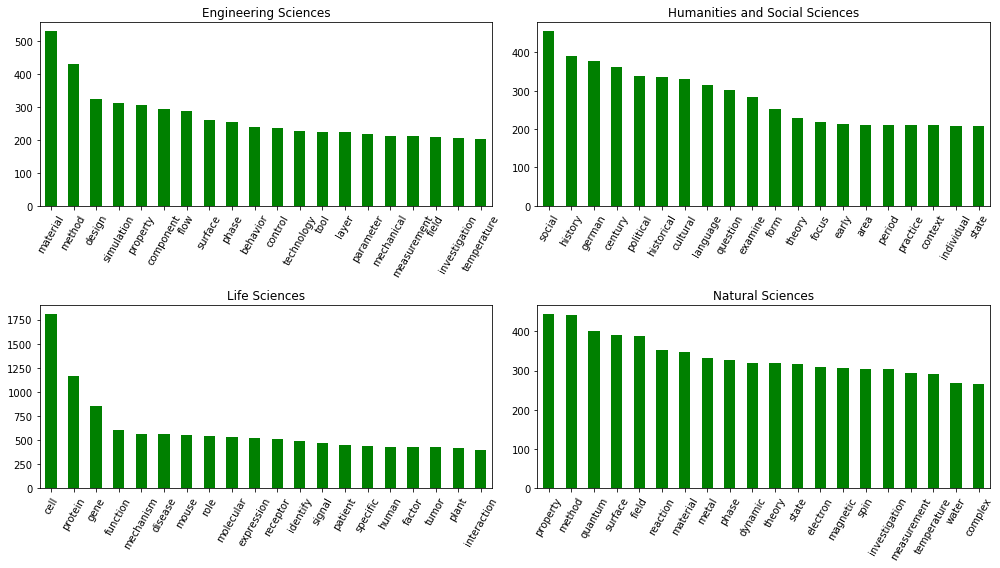

In [129]:
wordslist=merged_data.columns.tolist()[len(df.columns)+2:]

plt.subplots(figsize=(14,8)) 
i=1
categories=[]
category_words=[]

for cat,bucket in merged_data.groupby('Category'):
    
    plt.subplot(2,2,i)
    bucket[wordslist].sum().sort_values(ascending=False).head(20).plot(kind='bar',color='green')
    plt.title(cat)
    plt.xticks(rotation=60)
    i=i+1
    plt.tight_layout()
    categories.append(cat)
    category_words.append( ' '.join(bucket[wordslist].sum().sort_values(ascending=False).head(20).index.tolist()))

CategoryImpoWords=pd.DataFrame({'Category':categories,'Words':category_words})

In [131]:
## Repeated words in category

word=[]
for x in [cc.split() for cc in CategoryImpoWords.Words]:
    word.extend(x)
pd.Series(word).value_counts().sort_values(ascending=False).head(16)#.index.tolist()

theory           2
measurement      2
surface          2
property         2
state            2
field            2
investigation    2
method           2
phase            2
temperature      2
material         2
electron         1
history          1
mechanical       1
function         1
historical       1
dtype: int64

In [130]:
CategoryImpoWords.Words.tolist()

['material method design simulation property component flow surface phase behavior control technology tool layer parameter mechanical measurement field investigation temperature',
 'social history german century political historical cultural language question examine form theory focus early area period practice context individual state',
 'cell protein gene function mechanism disease mouse role molecular expression receptor identify signal patient specific human factor tumor plant interaction',
 'property method quantum surface field reaction material metal phase dynamic theory state electron magnetic spin investigation measurement temperature water complex']

In [523]:
direct_score=[]
with tqdm(total=size) as bar:
    for i in range(len(df.PreProcessedDescription)):
        topicWord=df.loc[i].PreProcessedDescription
        CatWords=CategoryImpoWords[CategoryImpoWords.Category==df.loc[i].Category].Words.values[0]
        direct_score.append(similarity_scores(topicWord, CatWords,50))
        bar.update(1)

  0%|          | 6/51033 [00:00<17:10, 49.52it/s]

Engineering Sciences : ocean engineering encompass wide variety area concerned underlying essential theory focus application practice fundamental aim postgraduate course interdisciplinary interdepartmental teamwork young mathematician engineer jointly develop new model establish mathematical background translate model numerical simulation major research topic program fluid load marine structure dynamic behavior system identification evaluation retrofit damaged underwater structure individual research activity program participant direct phd strongly support assist customized extensive seminar program special emphasis place ability recognize correlation relationship perceive overall context employ high end computation tool computer utilize state art software system multiple aspect construction material science damage detection evaluation fatigue life analysis robotic hydrodynamic foundation


100%|██████████| 51033/51033 [05:43<00:00, 148.37it/s]


In [524]:
df['direct_score']=direct_score

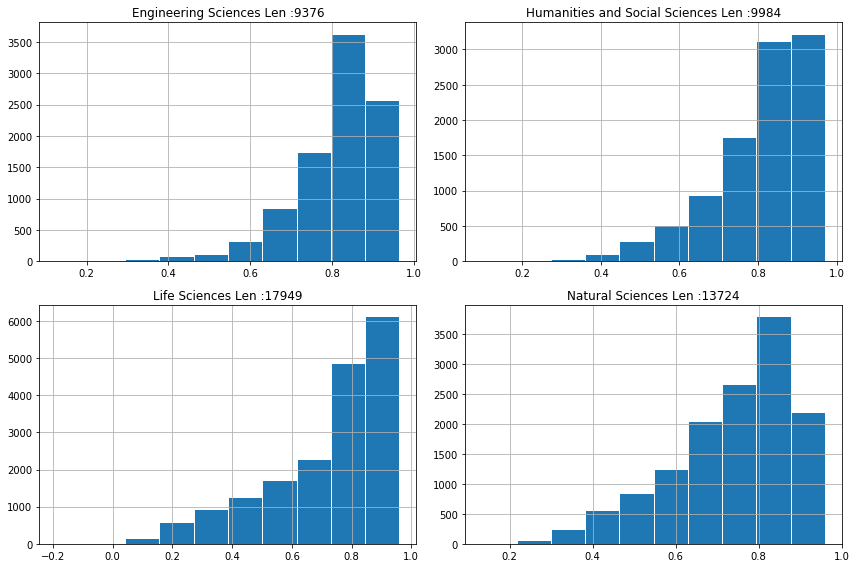

In [525]:
i=1
plt.figure(figsize=(12, 8))
for cc,w in df.groupby(['Category']):
    plt.subplot(2,2,i)
    w['direct_score'].hist( edgecolor='white', linewidth=1)    
    plt.title(str(cc)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [526]:
df['ProjectURL']=df.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
df1=df.merge(dbdf[['ProjectURL','interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL')

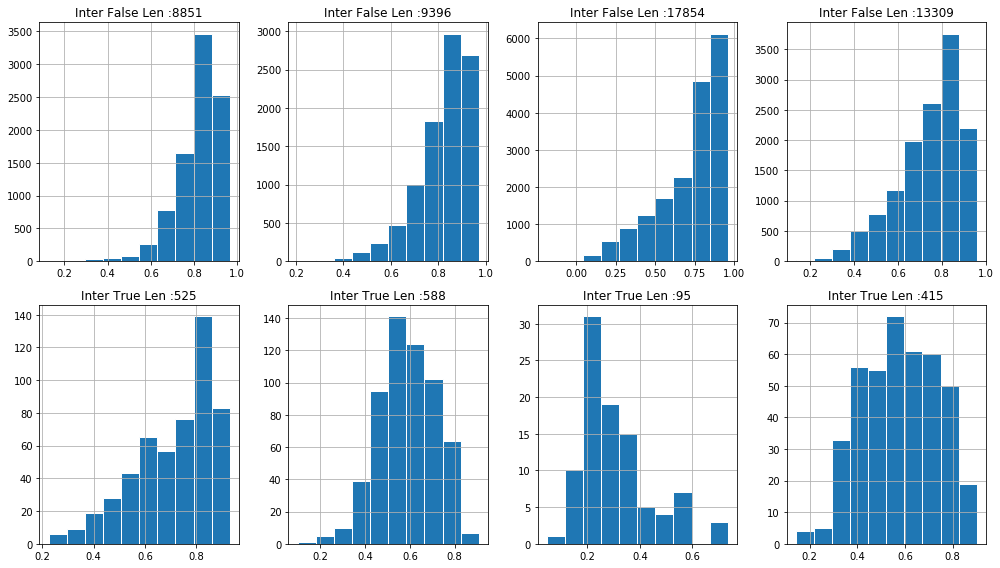

In [527]:
i=1
plt.figure(figsize=(14, 8))
for (intt,cc),w in df1.groupby(['interdiscipilinary','Category']):
    plt.subplot(2,4,i)
    w['direct_score'].hist( edgecolor='white', linewidth=1)    
    plt.title('Inter '+str(intt)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [536]:
df1['new_interdiscipilinary']=df1.apply(lambda x : 0.5>x['direct_score'],axis=1)

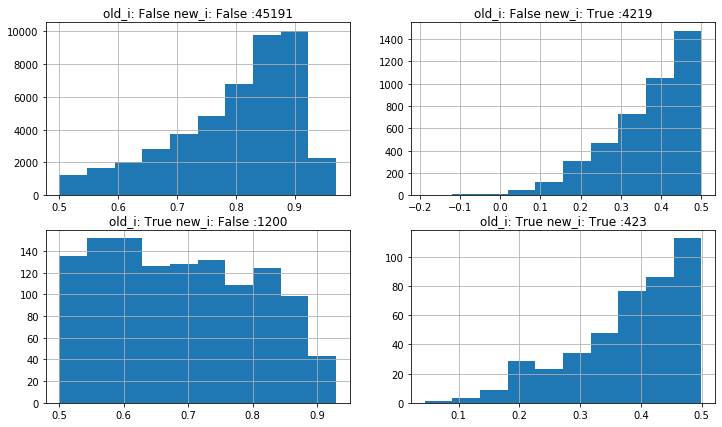

In [537]:
j=1
plt.figure(figsize=(12, 7))
for (old_i,new_i),w in df1.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    w['direct_score'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

In [534]:
df1[(df1['new_interdiscipilinary']) & (df1['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,File_Categories,Category,direct_score,ProjectURL,interdiscipilinary,new_interdiscipilinary
155,GRK 1070:&nbsp; Modelling Material Flows and P...,/gepris/projekt/425187,2004,2013,"Agriculture, Forestry and Veterinary Medicine",Universität Hohenheim,Agricultural food production in the North Chin...,Agricultural food production in the North Chin...,GRK 1070:&nbsp; Modelling Material Flows and P...,agricultural food production north china plain...,"Agriculture, Forestry and Veterinary Medicine",Life Sciences,0.181033,https://gepris.dfg.de/gepris/projekt/425187,False,True
158,GRK 1091:&nbsp; Orientation and Motion in Space,/gepris/projekt/449590,2005,2014,Neurosciences,Ludwig-Maximilians-Universität München,The Research Training Group for system-oriente...,The Research Training Group for system-oriente...,GRK 1091:&nbsp; Orientation and Motion in Space,research training group system orient neurobio...,Neurosciences,Life Sciences,0.098551,https://gepris.dfg.de/gepris/projekt/449590,False,True
337,Zentralprojekt,/gepris/projekt/5086502,1998,2005,Cognitive Neuroscience,Carl von Ossietzky Universität Oldenburg,Zur Förderung der Zusammenarbeit der Projekte ...,In order to promote the cooperation of project...,Central project,order promote cooperation project national wor...,Cognitive Neuroscience,Life Sciences,0.146836,https://gepris.dfg.de/gepris/projekt/5086502,False,True
743,Regionalisierung von N- und C-Spurengasemissio...,/gepris/projekt/5118628,1998,2004,Soil Sciences,Atmosphärische Umweltforschung (IMK-IFU),Ziele des Forschungsvorhabens sind a) die Erfa...,The objectives of the research project are a) ...,Regionalization of N and C trace gas emissions...,objective research project record complete ann...,Soil Sciences,Life Sciences,0.157474,https://gepris.dfg.de/gepris/projekt/5118628,False,True
854,Theoretische und experimentelle Untersuchungen...,/gepris/projekt/5127358,1998,2004,Plant Cultivation and Agricultural Technology,,"Es besteht das Ziel, mit Hilfe numerischer Sim...","The aim is to achieve, with the aid of numeric...",Theoretical and experimental investigations to...,aim achieve aid numerical simulation mass flow...,Plant Cultivation and Agricultural Technology,Life Sciences,0.158864,https://gepris.dfg.de/gepris/projekt/5127358,False,True
1295,Phytosociology of the montane forests of Mt. K...,/gepris/projekt/5156838,1999,2002,Plant Science,Universität Bayreuth,Der Kilimanjaro weist zur Zeit noch einen weit...,The Kilimanjaro currently has a largely closed...,Phytosociology of the montane forests of Mt. K...,kilimanjaro currently largely close forest bel...,Plant Science,Life Sciences,0.146885,https://gepris.dfg.de/gepris/projekt/5156838,False,True
1511,"Vegetationstypen, Sukzessions- und Regeneratio...",/gepris/projekt/5166096,1999,2003,Plant Science,Missouri Botanical Garden,Tropische Bergwälder gehören zu den artenreich...,Tropical mountain forests are among the most b...,"Vegetation types, succession and regeneration ...",tropical mountain forest biodiverse ecosystem ...,Plant Science,Life Sciences,0.154748,https://gepris.dfg.de/gepris/projekt/5166096,False,True
1701,Structure of functional modules from energy-tr...,/gepris/projekt/5172254,1999,2006,"Metabolism, Biochemistry and Genetics of Micro...",Universität zu Köln,Die Koordination eines DFG-Schwerpunktprogramm...,The coordination of a DFG priority program req...,Structure of functional modules from energy-tr...,coordination dfg priority program require numb...,"Metabolism, Biochemistry and Genetics of Micro...",Life Sciences,0.072789,https://gepris.dfg.de/gepris/projekt/5172254,False,True
1925,Evaluation eines Rechtschreibtrainingsprogramm...,/gepris/projekt/5178344,1999,2003,"Clinical Neurosciences II - Psychiatry, Psycho...",Klinikum der Universität München,3-9% der deutschen Schulkinder haben eine Lese...,3-9% of German schoolchildren h

In [535]:
df1[(df1['new_interdiscipilinary']) & (df1['Category']=='Life Sciences')].head(10).Translates.tolist()

['Agricultural food production in the North China Plain is characterised by high level production intensities, crop rotations and yields. Sustainability has not been taken into account in the development of ChinaÂ’s agriculture that has been mainly focused on raising productivity in order to meet the needs of a growing population with rising living standards. As a consequence, agricultural production in China entails serious environmental problems like reduced water availability, air and water pollution, and soil degradation. ',
 'The Research Training Group for system-oriented neurobiology is supported by scientific groups from different disciplines and faculties of the Ludwig Maximilians University (biology, clinical neurology, psychology), together with neurobiological groups from the Max Planck Institute for Neurobiology in Martinsried. The participating senior scientists together with their cooperating group members will provide optimal training, education and support for doctoral

In [ ]:
for j in CategoryImpoWords.Category:
    CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
    score=similarity_scores(topicWord, CatWords,50)
    print(j, score)

#### 1.1 Word Embedding

In [9]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=3, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list        
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [10]:
## creating a tagged document
#DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]


#tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [11]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.Word2Vec(DescDict,size=50, min_count=1, alpha = 0.02, sg=0, seed=42, workers=4)

#### Hyper parameter ####
print(str(datetime.datetime.now()),'Completed')

2020-03-03 20:26:06.182391 Started
2020-03-03 20:26:41.424461 Completed


In [404]:
## Validating the model response for random words 

modelchecked=model
target_word='biology'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=10), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'biology' model: Word2Vec(vocab=139448, size=50, alpha=0.02) similar words:
    1. 0.87 'biochemistry'
    2. 0.82 'virology'
    3. 0.80 'biophysic'
    4. 0.79 'biotechnology'
    5. 0.79 'immunology'
    6. 0.78 'microbiology'
    7. 0.76 'biologist'
    8. 0.74 'tol'
    9. 0.74 'pharmacology'
    10. 0.72 'edrecolomab'


In [410]:
modelchecked.similarity('love','machine')

/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.05965823

### LDA

In [134]:
###############################
#### LDA Topic Functions #####
###############################

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

#def make_bigram(inputlist):
#    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
#    bigram_phraser = Phraser(bigram)
#    new_list=[]
#    for sent in inputlist:
#        new_list.append(bigram_phraser[sent])
#    return new_list

def buildLDA(processed_docs, ip_num_topics=4):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    
    return dictionary,bow_corpus,corpus_tfidf#, lda_model_tfidf

def LDAtopicSummary(model, displaysubplot=[2,2]):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords',"Text"]
    return(sent_topics_df)

def build_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()
    out_df=[]
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel.get_document_topics(corpus)):
        row = sorted(row_list, key=lambda x: x[1], reverse=True)
        inn_df=[]
        for num,prob in row:
            inn_df.append(num)
            inn_df.append(prob)
        out_df.append(np.array(inn_df))
            
    return out_df

In [394]:
###############################
#### similarity functions #####
###############################

def map_word_frequency(document):
    return Counter(itertools.chain(*document))
    
def get_sif_feature_vectors(sentence1, sentence2, word_emb_model=model):
    sentence1 = [token for token in sentence1.split() if token in word_emb_model.wv.vocab]
    sentence2 = [token for token in sentence2.split() if token in word_emb_model.wv.vocab]
    word_counts = map_word_frequency((sentence1 + sentence2))
    embedding_size = 50 # size of vectore in word embeddings
    a = 0.0001
    sentence_set=[]
    for sentence in [sentence1, sentence2]:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return sentence_set

def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

def similarity_scores(sentence1, sentence2, n=10):
    sentence1=sentence1.replace(',','')
    sentence2=sentence2.replace(',','')
    features=get_sif_feature_vectors(sentence1, sentence2)
    return get_cosine_similarity(features[0][:n],features[1][:n])

In [420]:
topicWord='biology cels'
for j in CategoryImpoWords.Category:
    CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
    score=similarity_scores(topicWord, CatWords,50)
    print(j, score)

Engineering Sciences 0.07242564877211982
Humanities and Social Sciences 0.13842765799154372
Life Sciences 0.3825400903308396
Natural Sciences 0.09874828771145289


In [135]:
#docs=make_bigram(df["PreProcessedDescription"].map(preprocess))
docs=df["PreProcessedDescription"].map(preprocess)
print(str(len(docs))+' docs in input')
dictionary,bow_corpus,corpus_tfidf =buildLDA(docs)

51033 docs in input


In [486]:
#lda_model_tfidf = HdpModel(corpus_tfidf, id2word=dictionary,  random_state=42)
ip_num_topics=35
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, 
                                                 eta=[0.001]*len(dictionary.keys()), alpha =.001*ip_num_topics, random_state=42)

In [487]:
lda_model_tfidf.print_topics()

[(23,
  '0.025*"spin" + 0.024*"quantum" + 0.019*"magnetic" + 0.015*"electron" + 0.014*"electronic" + 0.011*"charge" + 0.009*"atom" + 0.009*"optical" + 0.009*"excitation" + 0.009*"molecule"'),
 (30,
  '0.026*"gene" + 0.019*"tumor" + 0.015*"cancer" + 0.013*"expression" + 0.013*"mutation" + 0.011*"mouse" + 0.011*"disease" + 0.009*"genome" + 0.009*"stem" + 0.009*"genetic"'),
 (13,
  '0.022*"climate" + 0.014*"sediment" + 0.012*"water" + 0.011*"isotope" + 0.010*"earth" + 0.008*"region" + 0.008*"global" + 0.007*"observation" + 0.007*"zone" + 0.007*"evolution"'),
 (29,
  '0.427*"food" + 0.083*"deposit" + 0.010*"acid" + 0.007*"regulatory" + 0.006*"earth" + 0.004*"energy" + 0.004*"gene" + 0.003*"conclusion" + 0.003*"plant" + 0.003*"content"'),
 (11,
  '0.022*"production" + 0.018*"tool" + 0.015*"planning" + 0.014*"product" + 0.011*"technology" + 0.010*"industrial" + 0.009*"machine" + 0.008*"quality" + 0.008*"industry" + 0.007*"micro"'),
 (4,
  '0.028*"problem" + 0.026*"algorithm" + 0.016*"optimiz

In [488]:
#pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary=lda_model_tfidf.id2word)

In [489]:
topic_words=[]
for i in range(ip_num_topics):
    topic_words.append(", ".join([word for (word, value) in lda_model_tfidf.show_topic(i)]))

TopicDesc=pd.DataFrame({'TopicNo':range(ip_num_topics), 'topic_words':topic_words})

TopicDesc['Category_1']=''
TopicDesc['Category_2']=''

for i in range(ip_num_topics):
    topicWord=TopicDesc[TopicDesc.TopicNo==i].topic_words.values[0].replace(',','')
    max_1=0
    max_2=0
    scores=[]
    
    for j in CategoryImpoWords.Category.tolist():
        CatWords=CategoryImpoWords[CategoryImpoWords.Category==j].Words.values[0]
        score=similarity_scores(topicWord, CatWords,50)
        TopicDesc.loc[TopicDesc.TopicNo==i, j]=score
        scores.append(score)
    if(pd.Series(scores).sort_values(ascending=False).head(1).values[0]>0.5):
        TopicDesc.loc[TopicDesc.TopicNo==i, 'Category_1']=CategoryImpoWords.Category.tolist()[pd.Series(scores).sort_values(ascending=False).head(1).index[0]]
        if(round(pd.Series(scores).sort_values(ascending=False).values[0]-pd.Series(scores).sort_values(ascending=False).values[1],2)<.05):
            TopicDesc.loc[TopicDesc.TopicNo==i, 'Category_2']=CategoryImpoWords.Category.tolist()[pd.Series(scores).sort_values(ascending=False).head(2).index[1]]

TopicDesc

,TopicNo,topic_words,Category_1,Category_2,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
0,0,"language, morphological, german, acquisition, ...",Humanities and Social Sciences,,0.441068,0.732753,0.220430,0.342813
1,1,"health, risk, outcome, survey, social, life, i...",Humanities and Social Sciences,,0.290069,0.593096,0.325564,0.106612
2,2,"layer, film, electron, crystal, temperature, s...",Natural Sciences,,0.727686,0.072163,0.137280,0.804686
3,3,"migration, direction, path, gradient, extracel...",Engineering Sciences,Life Sciences,0.665544,0.130674,0.663034,0.581625
4,4,"problem, algorithm, optimization, solution, eq...",Engineering Sciences,,0.641518,0.315692,0.151672,0.573861
5,5,"alloy, microstructure, heat, temperature, mech...",Engineering Sciences,,0.830642,0.252398,0.129627,0.742265
6,6,"enzyme, metabolism, metabolic, acid, plant, ge...",Life Sciences,,0.186926,-0.107159,0.658344,0.211297
7,7,"visual, stimulus, task, perception, learning, ...",Humanities and Social Sciences,,0.393126,0.568923,0.335547,0.315191
8,8,"text, century, history, german, historical, co...",Humanities and Social Sciences,,0.051395,0.867160,-0.184517,0.088364
9,9,"device, cluster, university, institute, reques...",,,0.404632,0.251554,-0.042669,0.462432


In [490]:
TopicDesc.topic_words.tolist()

['language, morphological, german, acquisition, morphology, feature, contact, variety, variation, collect',
 'health, risk, outcome, survey, social, life, intervention, assessment, assess, population',
 'layer, film, electron, crystal, temperature, substrate, defect, oxide, plasma, interface',
 'migration, direction, path, gradient, extracellular, gene, vivo, matrix, pressure, reaction',
 'problem, algorithm, optimization, solution, equation, solve, efficient, optimal, mathematical, error',
 'alloy, microstructure, heat, temperature, mechanical, strength, transformation, grain, treatment, composition',
 'enzyme, metabolism, metabolic, acid, plant, gene, substrate, pathway, compound, product',
 'visual, stimulus, task, perception, learning, cognitive, neural, processing, object, representation',
 'text, century, history, german, historical, collection, school, scientific, cultural, source',
 'device, cluster, university, institute, request, mass, biology, center, sample, need',
 'imagin

In [491]:
TopicDesc[TopicDesc['Category_1']=='']

,TopicNo,topic_words,Category_1,Category_2,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
9,9,"device, cluster, university, institute, reques...",,,0.404632,0.251554,-0.042669,0.462432
13,13,"climate, sediment, water, isotope, earth, regi...",,,0.444032,0.355055,-0.020196,0.482210
16,16,"specie, soil, plant, community, diversity, pop...",,,0.279056,0.394305,0.316055,0.244458
25,25,"user, communication, service, network, support...",,,0.459849,0.492507,0.133927,0.313000


In [493]:
TopicDesc.loc[9,'Category_1']='Humanities and Social Sciences'
TopicDesc.loc[13,'Category_1']='Natural Sciences'
TopicDesc.loc[16,'Category_1']='Natural Sciences'
TopicDesc.loc[25,'Category_1']='Engineering Sciences'
#TopicDesc

In [494]:
TopicDesc[TopicDesc['Category_1']==''].topic_words.tolist()

[]

In [476]:
for c1 in CategoryImpoWords.Category:
    CategoryImpoWords[c1]=0
    for c2 in CategoryImpoWords.Category:
         CategoryImpoWords.loc[CategoryImpoWords.Category==c2,c1]=similarity_scores(CategoryImpoWords.loc[CategoryImpoWords.Category==c1, 'Words'].values[0],  CategoryImpoWords.loc[CategoryImpoWords.Category==c2, 'Words'].values[0]
                                                                                    ,50)
CategoryImpoWords

,Category,Words,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
0,Engineering Sciences,material method design simulation property com...,1.000000,0.299695,0.218219,0.860837
1,Humanities and Social Sciences,social history german century political histor...,0.299695,1.000000,0.037859,0.322344
2,Life Sciences,cell protein gene function mechanism disease m...,0.218219,0.037859,1.000000,0.124005
3,Natural Sciences,property method quantum surface field reaction...,0.860837,0.322344,0.124005,1.000000


In [477]:
CategoryImpoWords.Words.tolist()

['material method design simulation property component flow surface phase behavior control technology tool layer parameter mechanical measurement field investigation temperature',
 'social history german century political historical cultural language question examine form theory focus early area period practice context individual state',
 'cell protein gene function mechanism disease mouse role molecular expression receptor identify signal patient specific human factor tumor plant interaction',
 'property method quantum surface field reaction material metal phase dynamic theory state electron magnetic spin investigation measurement temperature water complex']

In [495]:
size=len(df)

ls_expected_topic=[]
ls_expected_topic_cat=[]
ls_newwords=[]
ls_sim_score=[]

with tqdm(total=size) as bar:
    for i in range(size):
        result=lda_model_tfidf.get_document_topics(corpus_tfidf[i],per_word_topics=True)
        cids=[c_id  for (c_id,c_topic) in  result[1] if(c_topic)]
        
        if(len(result[0])>0):
            expected_topic=result[0][0][0]
            expected_topic_cat= TopicDesc.loc[TopicDesc.TopicNo==expected_topic,'Category_1'].values[0]
        else:
            expected_topic=-1
            expected_topic_cat=''
        newwords=' '.join([dictionary[i] for i in cids])
        
        ls_expected_topic.append(expected_topic)
        ls_expected_topic_cat.append(expected_topic_cat)
        ls_newwords.append(newwords)
        
        Catwords=CategoryImpoWords.loc[CategoryImpoWords.Category==df.loc[i,"Category"],'Words'].tolist()[0]   

        if((pd.isnull(newwords)==False) & (len(newwords)>=0) ):
            try:
                sim_score=similarity_scores(newwords,Catwords,20)
            except:
                #print(i,'Warning: Could not find the simlarity for -',newwords)
                pass

        
        ls_sim_score.append(sim_score)
        bar.update(1)
    
SimilarityPoints=pd.DataFrame({'Topic':ls_expected_topic, 'Top_Category':ls_expected_topic_cat,'Desc_words':ls_newwords, 'Similarity':ls_sim_score  })

100%|██████████| 51033/51033 [08:56<00:00, 95.05it/s] 


In [496]:
merged_df1=pd.concat([df,SimilarityPoints],ignore_index=True, axis=1)
merged_df1.columns=df.columns.tolist()+SimilarityPoints.columns.tolist()

In [497]:
merged_df1['ProjectURL']=merged_df1.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)

merged_df1=merged_df1.merge(dbdf[['ProjectURL','interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL')

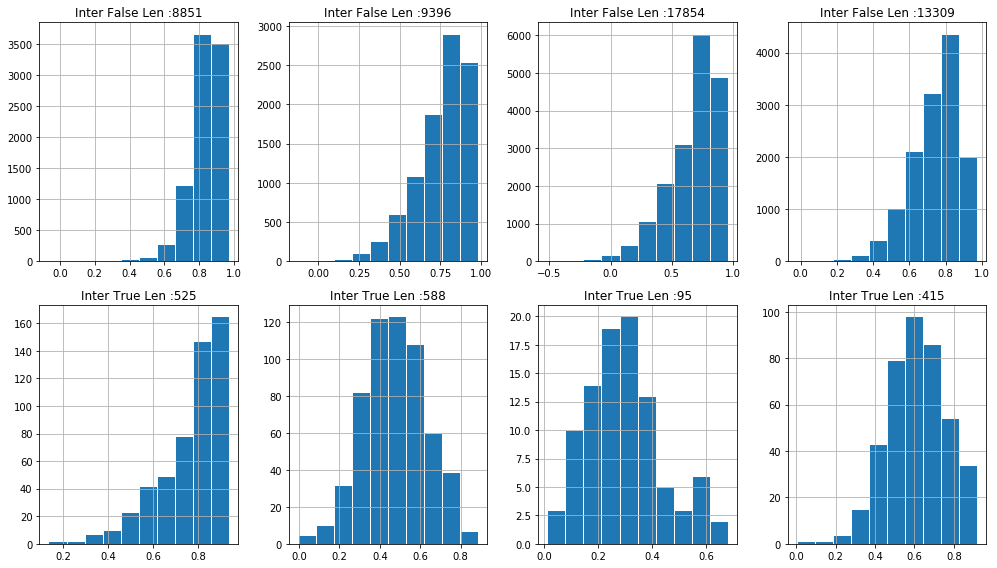

In [498]:
i=1
plt.figure(figsize=(14, 8))
for (intt,cc),w in merged_df1.groupby(['interdiscipilinary','Category']):
    plt.subplot(2,4,i)
    w['Similarity'].hist( edgecolor='white', linewidth=1)    
    plt.title('Inter '+str(intt)+' Len :'+str(len(w)))
    i=i+1
plt.tight_layout()

In [510]:
merged_df1['new_interdiscipilinary']=merged_df1.apply(lambda x : 0.5>x['Similarity'],axis=1)

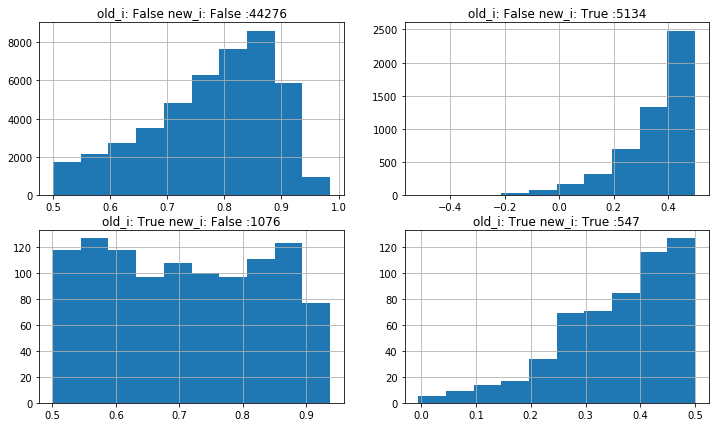

In [511]:
j=1
plt.figure(figsize=(12, 7))
for (old_i,new_i),w in merged_df1.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    w['Similarity'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

In [501]:
merged_df1[(merged_df1['new_interdiscipilinary'])].Category.value_counts()

Life Sciences                     610
Humanities and Social Sciences     51
Natural Sciences                   21
Engineering Sciences                9
Name: Category, dtype: int64

In [502]:
merged_df1[(merged_df1['interdiscipilinary']) & (merged_df1['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,File_Categories,Category,Topic,Top_Category,Desc_words,Similarity,ProjectURL,interdiscipilinary,new_interdiscipilinary
1113,Intertemporale Preisbildung im Lebensmittelein...,/gepris/projekt/5144738,1998,2002,Agricultural Economics and Sociology,Justus-Liebig-Universität Gießen,Die Studie soll einen Beitrag zur preistheoret...,The study should contribute to the price theor...,Intertemporal pricing in food retailing - theo...,study contribute price theory competition poli...,Agricultural Economics and Sociology,Life Sciences,11,Engineering Sciences,main theory aspect integration policy basic co...,0.120864,https://gepris.dfg.de/gepris/projekt/5144738,True,True
2962,Process safety of system spanning automatic co...,/gepris/projekt/5207488,1999,2006,Plant Cultivation and Agricultural Technology,Technische Universität München,Auf Anregung der Landtechnik-Vereinigung (LAV)...,At the suggestion of the Agricultural Engineer...,Process safety of system spanning automatic co...,suggestion agricultural engineering associatio...,Plant Cultivation and Agricultural Technology,Life Sciences,7,Humanities and Social Sciences,improve basic sensor solution entire general c...,0.277654,https://gepris.dfg.de/gepris/projekt/5207488,True,False
3158,Modellierung der dynamischen Belagsverteilung ...,/gepris/projekt/5212868,1999,2002,Plant Cultivation and Agricultural Technology,Bundesforschungsinstitut für Kulturpflanzen,Die Zusammenhänge zwischen Gestängebewegungen ...,The relationships between boom movements and p...,Modeling the dynamic coating distribution of f...,relationship boom movement pad distribution fi...,Plant Cultivation and Agricultural Technology,Life Sciences,14,Engineering Sciences,measure respect size relationship flow motion ...,0.315815,https://gepris.dfg.de/gepris/projekt/5212868,True,False
9934,Mathematische Modelle zum Infektionsprozess be...,/gepris/projekt/5372116,2002,2009,"Epidemiology, Medical Biometry, Medical Inform...",NaN,Onchozerkose (Flussblindheit) ist eine vor all...,Onchocerciasis (river blindness) is a parasito...,Mathematical models of the infection process i...,onchocerciasis river blindness parasitosis end...,"Epidemiology, Medical Biometry, Medical Inform...",Life Sciences,1,Humanities and Social Sciences,program consequence country future concern mea...,0.313813,https://gepris.dfg.de/gepris/projekt/5372116,True,False
16468,SFB 294:&nbsp; Moleküle in Wechselwirkung mit ...,/gepris/projekt/5476458,1994,2002,Physics,Universität Leipzig,The aim of the collaborative research centre 2...,The aim of the collaborative research centre 2...,SFB 294: & nbsp; Molecules in interaction with...,aim collaborative research centre investigatio...,Physics,Life Sciences,23,Natural Sciences,main program technology theory concept fundame...,0.234061,https://gepris.dfg.de/gepris/projekt/5476458,True,False
16484,SFB 428:&nbsp; Comples Macromolecular Network ...,/gepris/projekt/5480375,1997,2008,Chemistry,Albert-Ludwigs-Universität Freiburg,The interdisciplinary research within the Frei...,The interdisciplinary research within the Frei...,SFB 428:&nbsp; Comples Macromolecular Network ...,interdisciplinary research freiburg collaborat...,Chemistry,Life Sciences,34,Natural Sciences,science special basic network optical signal s...,0.277916,https://gepris.dfg.de/gepris/projekt/5480375,True,False
16787,SFB 677:&nbsp; Function by Switching,/gepris/projekt/13266514,2007,2019,Physics,Christian-Albrechts-Universität zu Kiel,Switching is an elementary step in information...,Switching is an elementary step in information...,SFB 677:&nbsp; Function by Switching,switching elementary step information technolo...,Physics,Life Sciences,23,Natural Sciences,improve natural offer science spatial technolo...,0.251187,https://gepris.dfg.de/gepris/projekt/13266514,True,False
16935,FOR 635:&nbsp; Quantum Control and Simulation ...,/g

In [503]:
merged_df1[(merged_df1['new_interdiscipilinary']) & (merged_df1['Category']=='Life Sciences')].head(10).PreProcessedDescription.tolist()

['research training group biological basis central nervous system diseases graduate program run researcher university leibniz institute neurobiology found medical faculty otto von guericke university magdeburg important aspect educational program aim bridge gap clinical basic research neuroscience research training group provide excellent research opportunity young investigator postgraduate level background interest biomedical research relate aspect brain disorder broad spectrum research topic reflect integrative research program combine state art technique interdisciplinary educational program program lead phd md degree md phd neurosciences qualify successful individual carreer track field brain research educate aspect life science magdeburg rapidly evolve neuroscience center germany group establish outstanding research program attract considerable extramural funding provide superb research facility research project molecular biochemical modern non invasive brain imaging technique pro

In [504]:
topic_df=pd.DataFrame(build_topics_sentences(lda_model_tfidf,corpus_tfidf))

In [505]:
merged_topic_df=topic_df.merge(TopicDesc,how='left', left_on=0, right_on='TopicNo')[[0, 1, 2, 3, 'topic_words','Category_1','Category_2']]
merged_topic_df=merged_topic_df.merge(TopicDesc,how='left', left_on=2, right_on='TopicNo')[[0, 1, 2, 3, 'topic_words_x','Category_1_x','Category_2_x','topic_words_y','Category_1_y','Category_2_y']]
merged_topic_df.columns=['Topic_1', 'Perc_cont_1', 'Topic_2', 'Perc_cont_2', 'important_topic_words_1','Category_1_1','Category_1_2', 'important_topic_words_2','Category_2_1','Category_2_2']
merged_topic_df=merged_topic_df.reset_index()[merged_topic_df.columns]

merged_df=pd.concat([df,merged_topic_df],ignore_index=True, axis=1)
merged_df.columns=df.columns.tolist()+merged_topic_df.columns.tolist()

In [506]:
merged_df['ProjectURL']=merged_df.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)

merged_df=merged_df.merge(dbdf[['ProjectURL','interdiscipilinary']],how='left', left_on='ProjectURL', right_on='ProjectURL')

In [507]:
merged_df['new_interdiscipilinary']=merged_df.apply(lambda x : x['Category']!=x['Category_1_1'],axis=1)

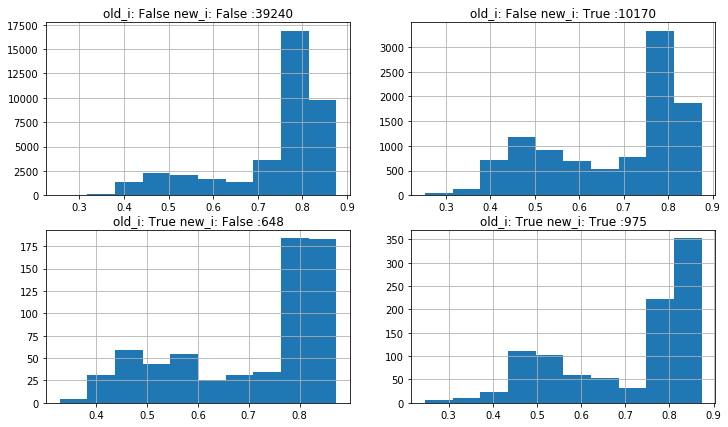

In [508]:
j=1
plt.figure(figsize=(12, 7))
for (old_i,new_i),w in merged_df.groupby(['interdiscipilinary','new_interdiscipilinary']):
    plt.subplot(2,2,j)
    w['Perc_cont_1'].hist()
    plt.title('old_i: '+str(old_i)+' new_i: '+str(new_i)+' :'+str(len(w)) )
    j=j+1

In [509]:
merged_df[(merged_df['new_interdiscipilinary']==True) & (merged_df1['Category']=='Life Sciences')].head(10)

,Name,SubUrl,FundingFrom,FundingEnd,SubjectArea,Institution,Description,Translates,Name_Translated,PreProcessedDescription,...,Perc_cont_2,important_topic_words_1,Category_1_1,Category_1_2,important_topic_words_2,Category_2_1,Category_2_2,ProjectURL,interdiscipilinary,new_interdiscipilinary
5,GRK 120:&nbsp; Signalling Cascades in Living S...,/gepris/projekt/269933,1998,2003,Fundamental Biological and Medical Research,Freie Universität Berlin,Studying signalling cascades in organisms requ...,Studying signalling cascades in organisms requ...,GRK 120:&nbsp; Signalling Cascades in Living S...,study signalling cascade organism require comp...,...,NaN,"user, communication, service, network, support...",Engineering Sciences,,NaN,NaN,NaN,https://gepris.dfg.de/gepris/projekt/269933,False,True
9,GRK 238:&nbsp; Mechanisms of Damage in CNS Dis...,/gepris/projekt/271095,1996,2004,Fundamental Biological and Medical Research,Humboldt-Universität zu Berlin,The aim of this research training group is a s...,The aim of this research training group is a s...,GRK 238:&nbsp; Mechanisms of Damage in CNS Dis...,aim research training group synthesis basic re...,...,0.217689,"text, century, history, german, historical, co...",Humanities and Social Sciences,,"imaging, tissue, image, vivo, animal, clinical...",Life Sciences,,https://gepris.dfg.de/gepris/projekt/271095,False,True
14,GRK 253:&nbsp; Biological Basis of Central Ner...,/gepris/projekt/271289,1996,2005,Fundamental Biological and Medical Research,Otto-von-Guericke-Universität Magdeburg,The research training group 'Biological Basis ...,The research training group 'Biological Basis ...,GRK 253:&nbsp; Biological Basis of Central Ner...,research training group biological basis centr...,...,NaN,"text, century, history, german, historical, co...",Humanities and Social Sciences,,NaN,NaN,NaN,https://gepris.dfg.de/gepris/projekt/271289,False,True
15,GRK 255:&nbsp; Signal Transduction in the Nerv...,/gepris/projekt/271315,1996,2004,Fundamental Biological and Medical Research,Universität Hamburg,The aim of this research training group is to ...,The aim of this research training group is to ...,GRK 255:&nbsp; Signal Transduction in the Nerv...,aim research training group offer interdiscipl...,...,NaN,"text, century, history, german, historical, co...",Humanities and Social Sciences,,NaN,NaN,NaN,https://gepris.dfg.de/gepris/projekt/271315,False,True
18,GRK 266:&nbsp; Analysis of the Functioning and...,/gepris/projekt/271437,1996,2005,Fundamental Biological and Medical Research,Friedrich-Schiller-Universität Jena,Practically all ecosystems on earth have been ...,Practically all ecosystems on earth have been ...,GRK 266:&nbsp; Analysis of the Functioning and...,practically ecosystem earth influence human ac...,...,0.207230,"text, century, history, german, historical, co...",Humanities and Social Sciences,,"climate, sediment, water, isotope, earth, regi...",Natural Sciences,,https://gepris.dfg.de/gepris/projekt/271437,False,True
19,GRK 268:&nbsp; Dynamics and Evolution of Cellu...,/gepris/projekt/271461,1997,2006,Fundamental Biological and Medical Research,Humboldt-Universität zu Berlin,The aim of the research training group is to e...,The aim of the research training group is to e...,GRK 268:&nbsp; Dynamics and Evolution of Cellu...,aim research training group elucidate structur...,...,0.239707,"problem, algorithm, optimization, solution, eq...",Engineering Sciences,,"text, century, history, german, historical, co...",Humanities and Social Sciences,,https://gepris.dfg.de/gepris/projekt/271461,False,True
21,GRK 276:&nbsp; Signal Recognition and Transduc...,/gepris/projekt/271543,1996,2005,Fundamental Biological and Medical Research,Freie Universität Berlin,The research training group 'Signal Recognitio...,The research training group 'Signal Recognitio...,GRK 276:&nbsp; Signal Recognition and Transduc...,research training group signal recognition tra...,...,0.312289,"text, century, history, german, historical, 

In [ ]:
merged_df[(merged_df['new_interdiscipilinary']==True) & (merged_df1['Category']=='Life Sciences')].head(10).Translates.tolist()

In [ ]:
for (t1,c11,c12),w in merged_df.groupby(['Topic_1','Category_1_1','Category_1_2']):
    print(t1,c11,c12)
    print(w.Category.value_counts())

In [ ]:
merged_df[['SubjectArea', 'File_Categories','Category', 'Topic_1',
       'Perc_cont_1', 'Topic_2', 'Perc_cont_2','Category_1_1','Category_1_2','Category_2_1','Category_2_2']].head()